<h1 align="center" style="margin-top:10px">Boosting</h1>

# Setting

In [ ]:
# Load dataset
#!pip3 install --upgrade oauth2client
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Please upload your csv on your google drive, give access to anyone, copy the link, and update the file ID and name.
google_docs = {
    '1j7HOEKLZctvRBl14vtglzYYzT-PIsiJd' : 'tutorial7.py',
    '1bQhKWLDYYW3NYGxYfY506B6lJ7Mk9G6Y' : 'tutorial2.py',
    '1ZhkHvU0bUYACMgnEnPDa61pdj1VC5F5y' : 'clean_store.csv',
    '1xXj4zNWaa9ETXKcIjORh18eRUpPWSWmq' : 'encoded_store.csv'
    
}


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for key in google_docs:
  drive.CreateFile({'id':key}).GetContentFile(google_docs[key])

In [ ]:
#!pip install cartopy
!pip install catboost
!pip install optuna
!pip install category_encoders
!pip install shap
#!pip install xgboost
#!pip install lightgbm
#!pip install pygam==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 20.9 MB/s eta 0:00:00


In [ ]:
# Requirements 
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost
import optuna
import sys

from sklearn.model_selection import train_test_split
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

from tutorial7 import plot_feature_importance

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
# print(f'cartopy {cartopy.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'xgboost {xgb.__version__}')
print(f'lightgbm {lgb.__version__}')
print(f'catboost {catboost.__version__}')
print(f'optuna {optuna.__version__}')

# Notebook tested on:

# numpy 1.23.5
# scipy 1.10.0
# pandas 1.5.2
# seaborn 0.12.2
# cartopy 0.21.1
# scikit-learn 1.2.0
# xgboost 1.6.1
# lightgbm 3.3.2
# catboost 1.0.6
# optuna 2.10.1


# Optional configuration

# This is to clear the warnings from the notebook, usually we should leave this on


ModuleNotFoundError: ignored

In [ ]:
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
%config InlineBackend.figure_format = 'retina'


In [ ]:
# Funtions
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

def plot_feature_importance(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    # feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

def booster_plot_feature_importance(model, labels, max_features = 20):
    # feature_importance = model.feature_importances_*100
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax



def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total Actuall Subscribed: ', np.sum(cm[1]))

In [ ]:
# Without encoding
store = pd.read_csv('clean_store.csv')


index_train_v, index_test = train_test_split(store.index, train_size=0.7, random_state=7)


train_v = store.loc[index_train_v, :].copy()
test = store.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='resp'].copy()
X_valid = valid.loc[:, test.columns!='resp'].copy()
X_test = test.loc[:, test.columns!='resp'].copy()

predictors = list(X_train.columns)

y_train = train['resp']
y_valid = valid['resp']
y_test = test['resp']

In [ ]:
X_train.head()

# Benchmark models

In [ ]:
store['fre'].describe()

In [ ]:
store[store['fre']<3]['resp'].describe()

##  Gradient boosting

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, n_estimators= 1901, subsample = 0.596)
gb.fit(X_train, y_train)

In [ ]:
# Importance
from tutorial7 import plot_feature_importance
plot_feature_importance(gb, predictors)
plt.show()

## HistGradientBoosting

In [ ]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(learning_rate = 0.01, max_depth = 8, max_iter = 1901)

hgb.fit(X_train, y_train)

## XGBoost

In [ ]:
%%time

import xgboost as xgb

xgbst = xgb.XGBClassifier(objective='binary:logistic', booster = 'gbtree', learning_rate = 0.02, 
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0
                        )

xgbst.fit(X_train, y_train)

In [ ]:
plot_feature_importance(xgbst, labels=predictors)
plt.show()

## CatBoost

In [ ]:
# One-hot
%%time
from catboost import CatBoostClassifier

cb = CatBoostClassifier(loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0
                      )
        
cb.fit(X_train, y_train)

# Important! If there were categorical features, you'd want to change the code to
# cb.fit(X_train, y_train, cat_features = cat_indices)
# where cat_indices is a one-dimensional array of indices indicating the categorical columns in X_train

In [ ]:
X_train['clustype']

In [ ]:
X_train

## LightGBM

In [ ]:
# One-hot
%%time
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(objective='binary', boosting_type = 'gbdt', 
                         n_estimators = 1974, learning_rate = 0.01,  
                         num_leaves = 24,
                         lambda_l1 = 0.0, lambda_l2 = 0.0,
                         bagging_fraction = 0.74, bagging_freq = 1, 
                         feature_fraction = 1.0, min_data_in_leaf = 1,
                         random_state = 7,
                        )

lgbm = lgbm.fit(X_train, y_train)

In [ ]:
plot_feature_importance(lgbm, labels=predictors)
plt.show()

## LightGBM Booster

In [ ]:
lgbm_train_data = lgb.Dataset(X_train, y_train, categorical_feature = [42])
lgbm_valid_data = lgb.Dataset(X_valid, y_valid, reference = lgbm_train_data)
lgbm_test_data = lgb.Dataset(X_test, y_test, reference = lgbm_train_data)

In [ ]:
params = { 'objective': 'binary',
          'boosting_type': 'gbdt',
          'learning_rate': 0.01,
          'num_leaves': 30,
          'lambda_l1': 2.4383347279286873,
          'lambda_l2': 8.379567222405476e-06,
          'bagging_fraction': 0.8709550987623199,
          'bagging_freq': 5,
          'feature_fraction': 0.5094556488498354,
          'min_data_in_leaf': 25,
          'feature_pre_filter': False,
          'verbosity': -1}
                

lgbmb = lgb.train(params, lgbm_train_data, num_boost_round=1000)

## Validation results

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score','Error Rate']

rows=['GBM', 'Histogram-based GBM',
      'XGBoost', 'CatBoost',  'LightGBM',
      'LightGBM Booster'
      ]

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [gb, hgb, xgbst, cb, lgbm,
           lgbmb
           ]

# y_prob1 = np.zeros((len(y_valid), len(rows)))
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    tau = 1/20

    if i==5:
        y_prob[:,i] = method.predict(X_valid)
        
    else:
        y_prob[:, i] = method.predict_proba(X_valid)[:, 1]

    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  19*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 
    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*9)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])
    results.iloc[i,7] =  f1_score(y_valid, y_pred)  #f1-score
    results.iloc[i,8] =   1 - accuracy_score(y_valid, y_pred) # error rate
   

results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

In [ ]:
results.sort_values(by=['AUC','F1-score'], ascending = [0,0]).round(3)

From the evaluation table above, we found GBM and LightGBM might be the best candidates for the reason that we value the cost of false negative rate more and the two models have relatively high Sensitivity and f1-score.

In [ ]:
# XGBoost - Test
method = xgbst

y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_valid, y_pred)

In [ ]:
# Histogram - Test
method = hgb

y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_valid, y_pred)

In [ ]:
# Gradient Boosting -valid
method = gb

y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_valid, y_pred)

In [ ]:
# LightGBM -valid
method = lgbm

y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_valid, y_pred)

In [ ]:
# LightGBM Booster Valid
method = lgbmb

y_prob = method.predict(X_valid)
y_pred = [1 if x >= tau else 0 for x in y_prob]
plot_cm(y_valid, y_pred)

We found Gradient Boost will be the best candidate for store data.

# Gradient Boost

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'learning_rate': 0.01, 
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'max_features': trial.suggest_uniform('max_features', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 128),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 128),
        'random_state': 7
    }

    gb = GradientBoostingClassifier(**params)

    # Cross-validation
    cv_scores = cross_val_score(gb, X_train, y_train, cv=10, scoring='neg_log_loss')

    # Save full set of parameters
    trial.set_user_attr('params', params)

    return cv_scores.mean()  # returns CV error for the best trial

sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, timeout=3600)

# Important! The higher the timeout, the better the chances of finding a good configuration.
# The time budget should be much higher in a real application.

In [ ]:
gb_params = study.best_trial.user_attrs['params']
# num_trees = study.best_trial.user_attrs['num_boost_round']

# print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
gb_params

In [ ]:
# Best 
%%time
from sklearn.ensemble import GradientBoostingClassifier


# Best parameters:
# {'learning_rate': 0.01,
#  'n_estimators': 1000,
#  'max_depth': 3,
#  'subsample': 0.761706290336883,
#  'max_features': 0.8752049295510174,
#  'min_samples_split': 86,
#  'min_samples_leaf': 60,
#  'random_state': 7}

best_gb = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 1000,
                                      max_depth = 3,
                                      subsample = 0.761706290336883,
                                      max_features = 0.8752049295510174,
                                      min_samples_split = 86,
                                      min_samples_leaf = 60,
                                      random_state = 7)

best_gb=best_gb.fit(X_train, y_train)

# learning rate
# Best parameters:
# {'learning_rate': 0.004116681529891354,
#  'n_estimators': 1000,
#  'max_depth': 5,
#  'subsample': 0.6861923446925295,
#  'max_features': 0.7387005774257942,
#  'min_samples_split': 48,
#  'min_samples_leaf': 108,
#  'random_state': 7}

best_gb2 = GradientBoostingClassifier(learning_rate = 0.004116681529891354,
                                       n_estimators = 1000,
                                       max_depth = 5,
                                       subsample = 0.6861923446925295,
                                       max_features = 0.7387005774257942,
                                       min_samples_split = 48,
                                       min_samples_leaf = 108,
                                       random_state = 7)
best_gb2=best_gb2.fit(X_train, y_train)

In [ ]:
best_gb2=best_gb2.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['Gradient Boosting - Valid','2']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [best_gb, best_gb2]


y_prob = np.zeros((len(y_valid), len(rows)))
for i, method in enumerate(methods):
      y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
      y_pred = method.predict(X_valid)
      tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

      results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
      results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
      results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
      results.iloc[i,3] =  tn/(tn+fp)  #specificity
      results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
      results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
      results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


   
results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

In [ ]:
# GBM - Valid
method = best_gb

y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# GBM - test - no threshhold
y_prob = method.predict_proba(X_test)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

# GBM - Test
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

y_prob = method.predict_proba(X_test)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

# XGBoost Classifer

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'booster' : 'gbtree',
        'learning_rate': 0.01, 
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 128),
        'verbosity': 0,
        'random_state': 7
    }

    clf = xgb.XGBClassifier(**params)

    # Cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_log_loss')

    # Save full set of parameters
    trial.set_user_attr('params', params)

    return cv_scores.mean()  # returns CV error for the best trial

sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=2000, timeout=3600)

# Important! The higher the timeout, the better the chances of finding a good configuration.

In [ ]:
xgb_params = study.best_trial.user_attrs['params']
# num_trees = study.best_trial.user_attrs['num_boost_round']

# print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
xgb_params

In [ ]:
%%time

import xgboost as xgb


best_xgbst = xgb.XGBClassifier(objective = 'binary:logistic',
                          learning_rate = 0.01,
                          n_estimators = 1000,
                          max_depth = 3,
                          reg_alpha = 0.7188294522825762,
                          reg_lambda = 0.04453764012065286,
                          subsample = 0.6066128691026624,
                          colsample_bytree = 0.9052269579587887,
                          min_child_weight = 24,
                          verbosity =0,
                          random_state = 7)

best_xgbst=best_xgbst.fit(X_train, y_train)

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['XGBoost - Valid']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [best_xgbst]

# y_prob1 = np.zeros((len(y_valid), len(rows)))
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):

    # if method == methods[5]:
    #     y_prob = method.predict(X_valid)
    #     y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
    #     results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
    #     results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
    #     results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
    #     results.iloc[i,3] =  tn/(tn+fp)  #specificity
    #     results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
    #     results.iloc[i,5] =  roc_auc_score(y_valid, y_prob)  # AUC
    #     results.iloc[i,6] =  log_loss(y_valid, y_prob)   #Corss-entropy

        
    # else:
      y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
      y_pred = method.predict(X_valid)
      tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

      results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
      results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
      results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
      results.iloc[i,3] =  tn/(tn+fp)  #specificity
      results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
      results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
      results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

In [ ]:
# XGBoost - Valid
method = best_xgbst



y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(X_test)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

# GBM - Test
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

y_prob = method.predict_proba(X_test)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

# LightGBM Classifier

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'objective': 'binary',
        'learning_rate': 0.01, 
        'n_estimators': 1000,
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 128),
        'verbose': -1,
        'metric': 'binary_logloss'
    }

    clf = lgb.LGBMClassifier(**params)

    # Cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_log_loss')

    # Save full set of parameters
    trial.set_user_attr('params', params)

    return cv_scores.mean()  # returns CV error for the best trial

sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, timeout=3600)  # Increase the timeout value

# Important! The higher the timeout, the better the chances of finding a good configuration.
# The time budget should be much higher in a real application.

In [ ]:
lgbm_params = study.best_trial.user_attrs['params']
# num_trees = study.best_trial.user_attrs['num_boost_round']

# print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
lgbm_params

In [ ]:
%%time
import lightgbm as lgb

best_lgbm_c = lgb.LGBMClassifier(objective = 'binary',
                               learning_rate = 0.01,
                               n_estimators = 1000,
                               num_leaves = 4,
                               reg_alpha = 0.21215772927733817,
                               reg_lambda = 4.0468516923374466e-05,
                               subsample = 0.6437621101709328,
                               colsample_bytree = 0.9789740252242091,
                               min_child_samples = 120,
                               random_state = 7,
                               verbose = -1,
                               metric = 'binary_logloss')

best_lgbm_c = best_lgbm_c.fit(X_train, y_train)

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['LightGBM Classifier - Valid']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [best_lgbm_c]

# y_prob1 = np.zeros((len(y_valid), len(rows)))
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
      y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
      y_pred = (y_prob[:,0] > 1/20).astype(int)
      # y_pred = method.predict(X_valid)
      tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

      results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
      results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
      results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
      results.iloc[i,3] =  tn/(tn+fp)  #specificity
      results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
      results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
      results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

,Sensitivity,F1-score,Error Rate,Specificity,Precision,AUC,Cross-entropy
LightGBM - Valid,0.284,0.402,0.145,0.973,0.688,0.863,0.323


(True Negatives):  2455
(False Positives):  67
(False Negatives):  374
(True Positives):  148
Total Actuall Subscribed:  522
(True Negatives):  5265
(False Positives):  153
(False Negatives):  787
(True Positives):  318
Total Actuall Subscribed:  1105
(True Negatives):  2425
(False Positives):  2993
(False Negatives):  32
(True Positives):  1073
Total Actuall Subscribed:  1105


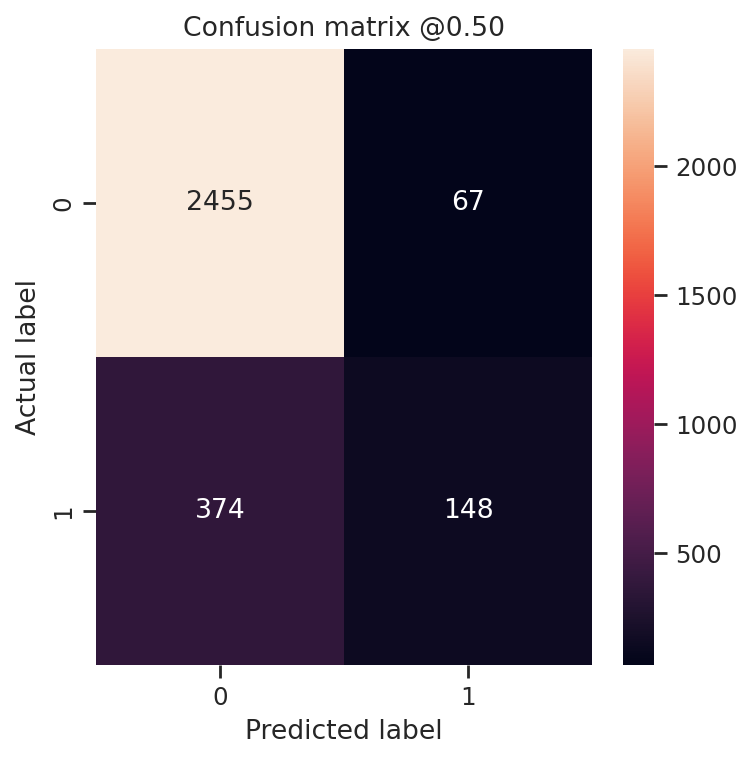

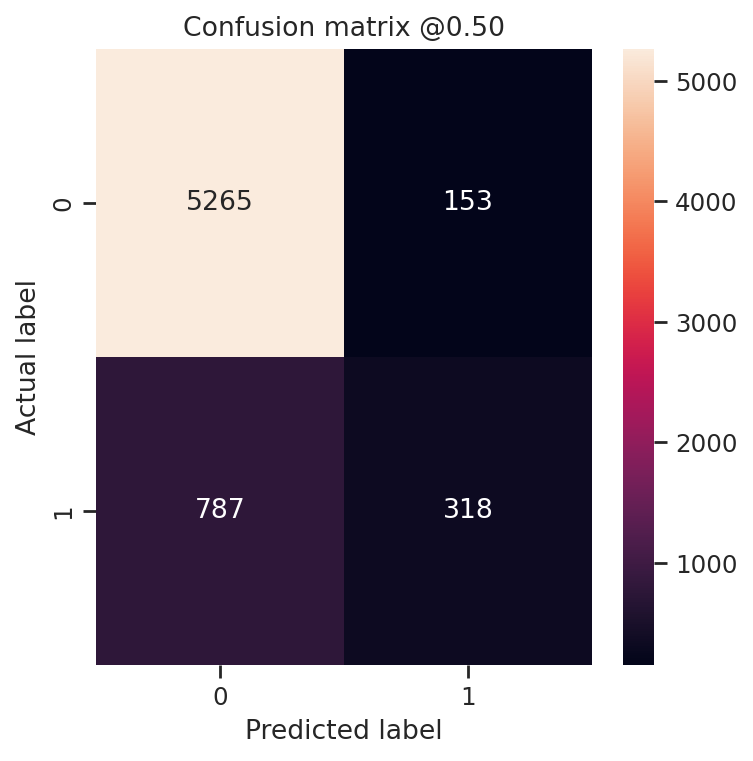

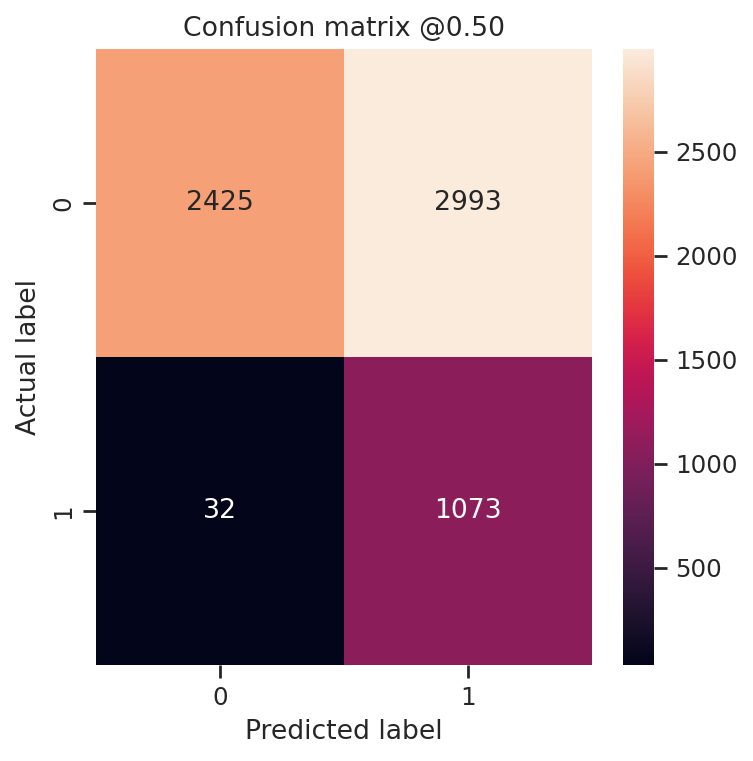

In [ ]:
# XGBoost - Valid
method = best_lgbm_c



y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(X_test)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

# GBM - Test
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

y_prob = method.predict_proba(X_test)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

# LightGBM Booster

In [ ]:
lgbm_train_data = lgb.Dataset(X_train, y_train)
lgbm_valid_data = lgb.Dataset(X_valid, y_valid, reference = lgbm_train_data)
lgbm_test_data = lgb.Dataset(X_test, y_test, reference = lgbm_train_data)

In [ ]:
# We have to reconstruct the dataset to tune min_data_in_leaf
from optuna.samplers import TPESampler


def objective(trial):
    
    params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1
     }
    
    # Cross-validation 
    history = lgb.cv(params, lgbm_train_data, num_boost_round = 1000, 
                     nfold = 10, stratified = False, early_stopping_rounds = 50, verbose_eval=0)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['binary_logloss-mean']))
    
    return history['binary_logloss-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 7) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=2000, timeout = 2400)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2023-05-18 09:18:09,626] A new study created in memory with name: no-name-a7c12de5-ba72-4d2a-9b2d-2bb5e036d43a
[I 2023-05-18 09:18:44,865] Trial 0 finished with value: 0.32866196026691635 and parameters: {'num_leaves': 6, 'lambda_l1': 0.10453678278574731, 'lambda_l2': 8.824357269705966e-05, 'bagging_fraction': 0.8617325889154706, 'bagging_freq': 10, 'feature_fraction': 0.7692479352052168, 'min_data_in_leaf': 65}. Best is trial 0 with value: 0.32866196026691635.
[I 2023-05-18 09:19:25,694] Trial 1 finished with value: 0.32892583592978103 and parameters: {'num_leaves': 6, 'lambda_l1': 2.605858448423918e-06, 'lambda_l2': 0.0003154586986665377, 'bagging_fraction': 0.8396149980604702, 'bagging_freq': 9, 'feature_fraction': 0.6904705665742692, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.32866196026691635.
[I 2023-05-18 09:19:57,223] Trial 2 finished with value: 0.3311825059705359 and parameters: {'num_leaves': 20, 'lambda_l1': 1.5358250592890428, 'lambda_l2': 8.326609203905651e-

In [ ]:
lgbm_params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
lgbm_params

Number of boosting iterations: 784 

Best parameters:


{'objective': 'binary',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 6,
 'lambda_l1': 0.11405609272878144,
 'lambda_l2': 0.026615744329697977,
 'bagging_fraction': 0.7334404241713197,
 'bagging_freq': 4,
 'feature_fraction': 0.8680380019873142,
 'min_data_in_leaf': 102,
 'feature_pre_filter': False,
 'verbosity': -1}

In [ ]:
best_params = {'objective': 'binary',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 6,
                'lambda_l1': 0.11405609272878144,
                'lambda_l2': 0.026615744329697977,
                'bagging_fraction': 0.7334404241713197,
                'bagging_freq': 4,
                'feature_fraction': 0.8680380019873142,
                'min_data_in_leaf': 102,
                'feature_pre_filter': False,
                'verbosity': -1}


best_lgbm = lgb.train(best_params, lgbm_train_data, num_boost_round=1000)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['Best - LightBoost - Valid']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_lgbm]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(X_valid)
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
Best - LightBoost - Valid,0.147,0.282,0.972,0.674,0.862,0.323,0.397


(True Negatives):  2451
(False Positives):  71
(False Negatives):  375
(True Positives):  147
Total Actuall Subscribed:  522
(True Negatives):  5264
(False Positives):  154
(False Negatives):  777
(True Positives):  328
Total Actuall Subscribed:  1105
(True Negatives):  2527
(False Positives):  2891
(False Negatives):  39
(True Positives):  1066
Total Actuall Subscribed:  1105


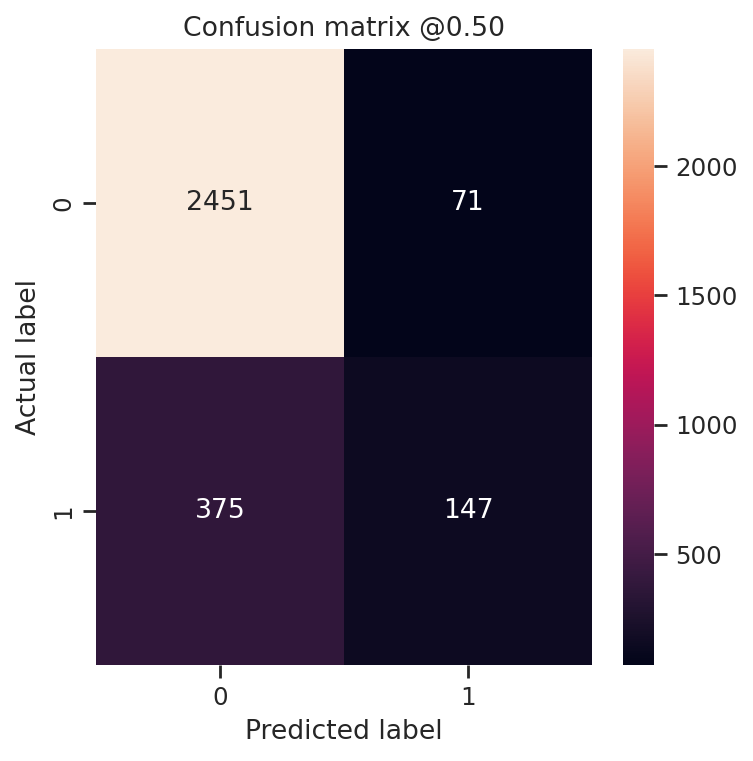

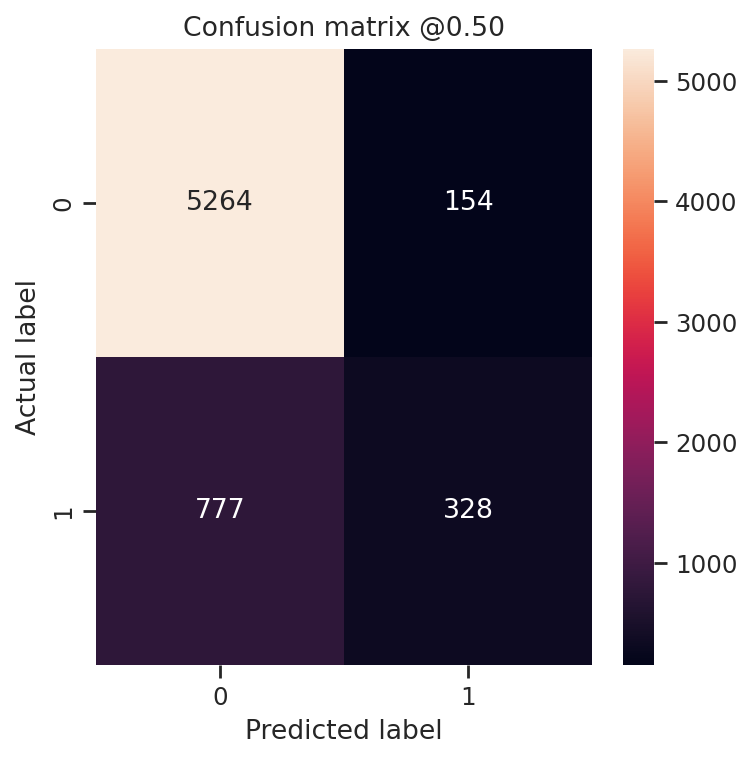

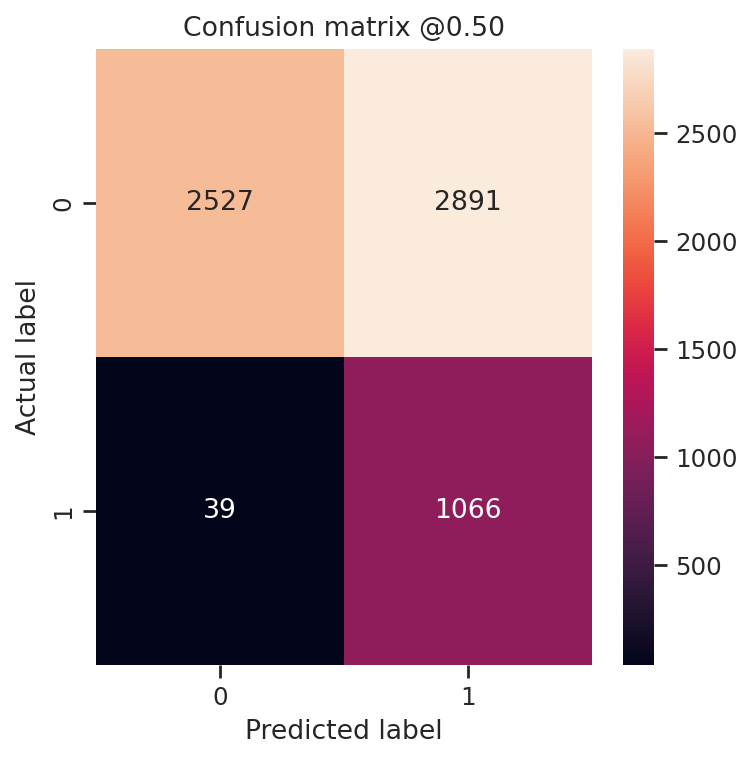

In [ ]:
# XGBoost - Valid
method = best_lgbm


y_prob = method.predict(X_valid)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

# GBM - Test
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

y_prob = method.predict(X_test)
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

# Summary

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']
         
rows=['Gradient Boosting - Valid', 'XGBoost - Valid',
      'LightBoost Classifier - Valid', 'LightBoost Booster - Valid',]
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_gb, best_xgbst, 
         best_lgbm_c, 
         best_lgbm]

y_prob = np.zeros((len(y_valid), len(rows)))
for i, method in enumerate(methods):

    if method == methods[3]:
        y_prob = method.predict(X_valid)
        y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()  # Add this line
        
        results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
        results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
        results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
        results.iloc[i,3] =  tn/(tn+fp)  #specificity
        results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
        results.iloc[i,5] =  roc_auc_score(y_valid, y_prob)  # AUC
        results.iloc[i,6] =  log_loss(y_valid, y_prob)   #Cross-entropy

        
    else:
        # y_prob = method.predict_proba(X_valid)[:, 1]
        y_prob = method.predict_proba(X_valid)[:, 1]
        y_pred = method.predict(X_valid)
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

        results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
        results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
        results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
        results.iloc[i,3] =  tn/(tn+fp)  #specificity
        results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
        results.iloc[i,5] =  roc_auc_score(y_valid, y_prob)  # AUC
        results.iloc[i,6] =  log_loss(y_valid, y_prob)   #Corss-entropy



results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,Cross-entropy,AUC,F1-score
Gradient Boosting - Valid,0.289,0.405,0.146,0.971,0.677,0.862,0.325
LightBoost Classifier - Valid,0.284,0.402,0.145,0.973,0.688,0.863,0.323
LightBoost Booster - Valid,0.282,0.397,0.147,0.972,0.674,0.862,0.323
XGBoost - Valid,0.285,0.402,0.146,0.972,0.680,0.863,0.323


# Gradient Boost tuned by F1

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),  # tune the learning rate
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'max_features': trial.suggest_uniform('max_features', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 128),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 128),
        'random_state': 7
    }

    gb = GradientBoostingClassifier(**params)

    # Cross-validation
    cv_scores = cross_val_score(gb, X_train, y_train, cv=10, scoring='f1')

    # Save full set of parameters
    trial.set_user_attr('params', params)

    return cv_scores.mean()  # returns CV error for the best trial

sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, timeout=3600)

# Important! The higher the timeout, the better the chances of finding a good configuration.
# The time budget should be much higher in a real application.

[I 2023-05-20 03:37:29,055] A new study created in memory with name: no-name-0f1c0b04-1a28-431a-93e1-6624c0ed7b29
[I 2023-05-20 03:44:47,728] Trial 0 finished with value: 0.3977437670513795 and parameters: {'max_depth': 3, 'subsample': 0.8899593961200574, 'max_features': 0.7192046157204468, 'min_samples_split': 93, 'min_samples_leaf': 126}. Best is trial 0 with value: 0.3977437670513795.
[I 2023-05-20 03:52:00,663] Trial 1 finished with value: 0.4037288964654798 and parameters: {'max_depth': 6, 'subsample': 0.7505602318299689, 'max_features': 0.5360255666798808, 'min_samples_split': 36, 'min_samples_leaf': 64}. Best is trial 1 with value: 0.4037288964654798.
[I 2023-05-20 04:04:39,351] Trial 2 finished with value: 0.3996668887733839 and parameters: {'max_depth': 7, 'subsample': 0.9018695180521877, 'max_features': 0.6904705665742692, 'min_samples_split': 10, 'min_samples_leaf': 37}. Best is trial 1 with value: 0.4037288964654798.
[I 2023-05-20 04:14:56,538] Trial 3 finished with value: 

In [ ]:
gb_params_f1 = study.best_trial.user_attrs['params']

print('Best parameters:')
gb_params_f1

Best parameters:


{'learning_rate': 0.01,
 'n_estimators': 1000,
 'max_depth': 6,
 'subsample': 0.7505602318299689,
 'max_features': 0.5360255666798808,
 'min_samples_split': 36,
 'min_samples_leaf': 64,
 'random_state': 7}

In [ ]:
# Best 
%%time
from sklearn.ensemble import GradientBoostingClassifier


# Best parameters:
# {'learning_rate': 0.01,
#  'n_estimators': 1000,
#  'max_depth': 6,
#  'subsample': 0.7505602318299689,
#  'max_features': 0.5360255666798808,
#  'min_samples_split': 36,
#  'min_samples_leaf': 64,
#  'random_state': 7}

gb_f1 = GradientBoostingClassifier(learning_rate = 0.01,
                                   n_estimators = 1000,
                                   max_depth = 6,
                                   subsample = 0.7505602318299689,
                                   max_features = 0.5360255666798808,
                                   min_samples_split = 36,
                                   min_samples_leaf = 64,
                                   random_state = 7)
gb_f1 = gb_f1.fit(X_train, y_train)

CPU times: user 51.1 s, sys: 75.9 ms, total: 51.2 s
Wall time: 54.3 s


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['Gradient Boosting','Gradient Boosting tuned  by F1']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [best_gb,gb_f1]


y_prob = np.zeros((len(y_valid), len(rows)))
for i, method in enumerate(methods):
      y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
      y_pred = method.predict(X_valid)
      tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

      results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
      results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
      results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
      results.iloc[i,3] =  tn/(tn+fp)  #specificity
      results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
      results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
      results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


   
results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(5)

,Sensitivity,F1-score,Error Rate,Specificity,Precision,AUC,Cross-entropy
Gradient Boosting tuned by F1,0.310,0.420,0.147,0.966,0.651,0.861,0.325
Gradient Boosting,0.289,0.405,0.146,0.971,0.677,0.862,0.325


(True Negatives):  2435
(False Positives):  87
(False Negatives):  360
(True Positives):  162
Total Actuall Subscribed:  522
(True Negatives):  5235
(False Positives):  183
(False Negatives):  756
(True Positives):  349
Total Actuall Subscribed:  1105
(True Negatives):  2699
(False Positives):  2719
(False Negatives):  51
(True Positives):  1054
Total Actuall Subscribed:  1105


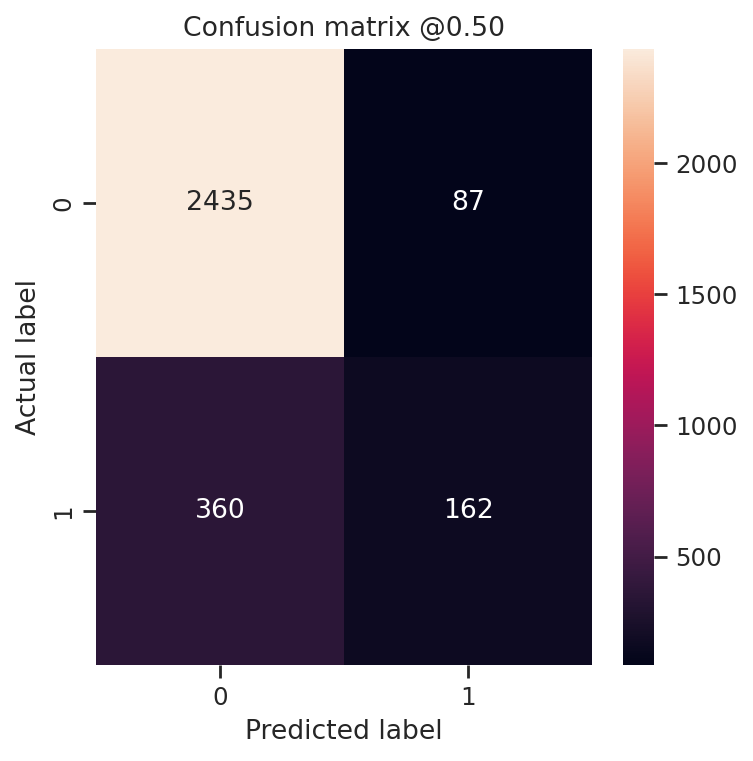

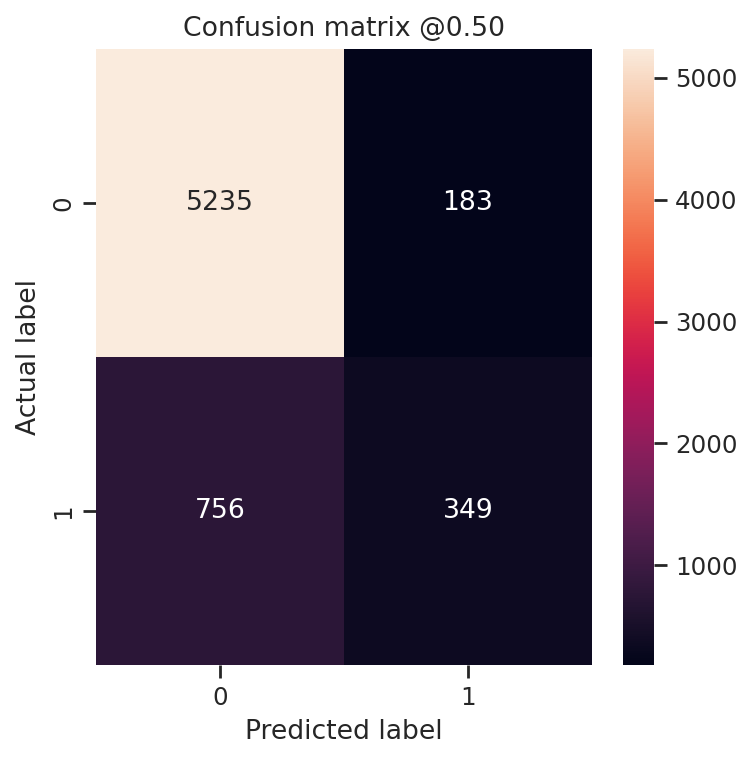

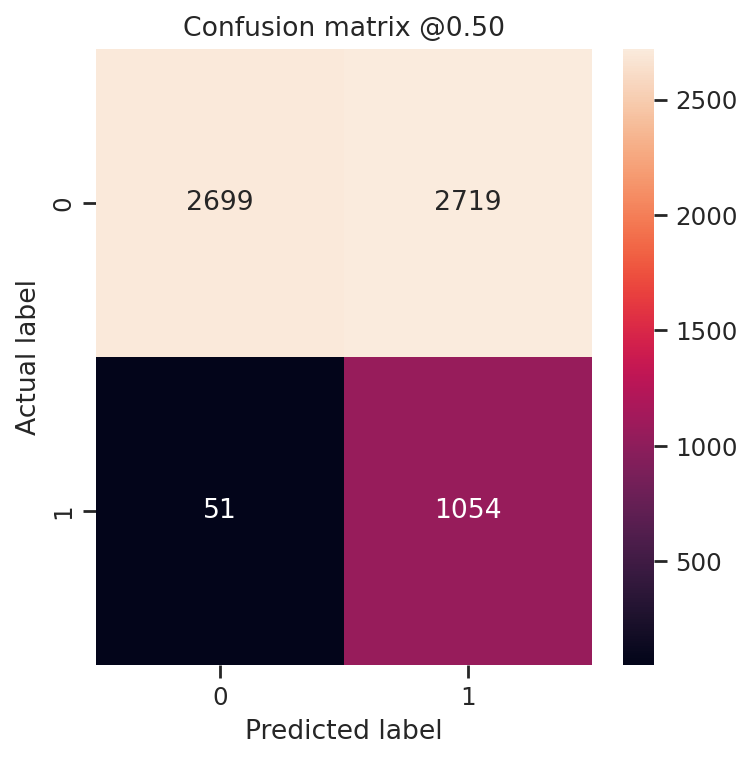

In [ ]:
# GBM - Valid
method = gb_f1

y_prob = method.predict_proba(X_valid)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# GBM - test - no threshhold
y_prob = method.predict_proba(X_test)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

# GBM - Test
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

y_prob = method.predict_proba(X_test)[:, 1]
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

# 😋😋😋 Old Code Below 😋😋😋

 # Test

In [ ]:
#convert the dataset into the LightGBM format.
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

test_data = lgb.Dataset(X_test, y_test, reference = train_data)

In [ ]:
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['LightGBM - Test']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[lgbm]

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(X_test)
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_test, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_test, y_prob)
    results.iloc[i,5] =  log_loss(y_test, y_prob)
   

results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
LightGBM - Test,0.108,0.264,0.979,0.631,0.8,0.287


In [ ]:
y_prob = lgbm.predict(X_test)


# y_pred_labels = [1 if x >= 0.5 else 0 for x in y_pred]

# y_prob = 1 / (1 + np.exp(-y_pred))

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5


y_pred = (y_prob > tau).astype(int)

(True Negatives):  8859
(False Positives):  921
(False Negatives):  574
(True Positives):  776
Total Actuall Subscribed:  1350


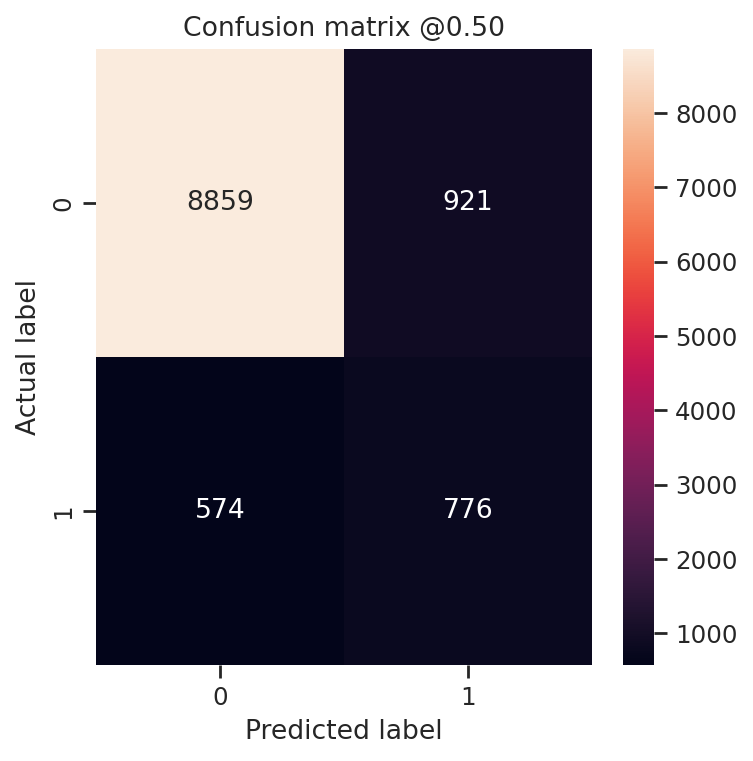

In [ ]:
plot_cm(y_test, y_pred)